In [ ]:
import pandas as pd
import numpy as np
import pickle
import json
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

In [ ]:
df = pd.read_excel('milano_housing_02_2_23.xlsx')
df.head()

,index,rooms,m2,bathrooms,floor,condominium_expenses,date,contract,typology,total_floors,...,energy_certification,co2_emissions,elevator,floor_level,heating_centralized,heating_radiator,heating_gas,air_conditiong_centralized,air_conditioning_heat,renewable_energy_performance_index_KWh/m2
0,0,3,140.0,2,4,535,08/02/2023,sale,apartment | entire property | stately property...,6 floors,...,NaN,NaN,1,4,centralized,to radiators,methane powered,autonomous,cold/hot,NaN
1,0,4,121.0,2,3,200,17/02/2023,sale,apartment | entire property | stately property...,7 floors,...,NaN,NaN,1,3,autonomous,to radiators,gas powered,system preparation,NaN,NaN
2,0,2,55.0,1,4,133,20/02/2023,sale,attic | entire property | stately property class,4 floors,...,NaN,NaN,1,4,autonomous,to radiators,gas powered,autonomous,cold/hot,NaN
3,0,2,60.0,1,5,333,11/01/2023,sale,attic | bare ownership | medium property class,5 floors,...,NaN,NaN,1,5,centralized,to radiators,methane powered,autonomous,cold,NaN
4,0,4,220.0,3,4,NaN,23/01/2023,sale,apartment | entire property | stately property...,7 floors,...,NaN,NaN,1,4,centralized,to radiators,methane powered,autonomous,cold/hot,351.0


In [ ]:
df.shape

(2130, 34)

In [ ]:
df.groupby('neighborhood')['neighborhood'].agg('count')

neighborhood
affori                   20
amendola - buonarroti     9
arco della pace          11
arena                    11
argonne - corsica        22
                         ..
vigentino - fatima       43
villa san giovanni        9
vincenzo monti           17
washington               20
zara                     10
Name: neighborhood, Length: 145, dtype: int64

## Data Cleaning

In [ ]:
#df1 = df.drop(['condominium_expenses','date','contract','typology',
#               'total_floors','availability','other_features',
#               'condition','air_conditioning','energy_efficiency',
#               'city',], axis='columns')
df1 = df[['rooms','m2','bathrooms','price','year_of_build','neighborhood',
          'heating_centralized', 'elevator']]
df1.head()

,rooms,m2,bathrooms,price,year_of_build,neighborhood,heating_centralized,elevator
0,3,140.0,2,880000.0,1900.0,centrale,centralized,1
1,4,121.0,2,649000.0,1960.0,centrale,autonomous,1
2,2,55.0,1,300000.0,2006.0,viale ungheria - mecenate,autonomous,1
3,2,60.0,1,250000.0,1960.0,città studi,centralized,1
4,4,220.0,3,2250000.0,1970.0,piave - tricolore,centralized,1


In [ ]:
# Check for null values
df1.isnull().sum()

rooms                   14
m2                      17
bathrooms               25
price                  143
year_of_build          237
neighborhood            14
heating_centralized     55
elevator                 0
dtype: int64

In [ ]:
df2 = df1.dropna()
df2.shape

(1839, 8)

In [ ]:
df2['rooms'].unique()

array(['3', '4', '2', '5', '1', '5+', '110m²'], dtype=object)

In [ ]:
df2 = df2[~df2.rooms.str.contains('m')]
df2.shape

(1838, 8)

## Feature Engineering

In [ ]:
df2['price_per_sqm'] = df2['price']/df2['m2']
df2.head()

,rooms,m2,bathrooms,price,year_of_build,neighborhood,heating_centralized,elevator,price_per_sqm
0,3,140.0,2,880000.0,1900.0,centrale,centralized,1,6285.714286
1,4,121.0,2,649000.0,1960.0,centrale,autonomous,1,5363.636364
2,2,55.0,1,300000.0,2006.0,viale ungheria - mecenate,autonomous,1,5454.545455
3,2,60.0,1,250000.0,1960.0,città studi,centralized,1,4166.666667
4,4,220.0,3,2250000.0,1970.0,piave - tricolore,centralized,1,10227.272727


In [ ]:
len(df2.neighborhood.unique())

141

In [ ]:
neighborhood_stats = df2.groupby('neighborhood')['neighborhood'].agg('count').sort_values(ascending=False)
neighborhood_stats

neighborhood
città studi                 76
san siro                    57
sempione                    55
centrale                    50
certosa                     48
                            ..
via giuseppina lazzaroni     1
via dei ciclamini 11         1
ortica                       1
rogoredo                     1
parco lambro                 1
Name: neighborhood, Length: 141, dtype: int64

In [ ]:
len(neighborhood_stats[neighborhood_stats<=5])

34

In [ ]:
neighborhood_stats_less = neighborhood_stats[neighborhood_stats<=5]
neighborhood_stats_less

neighborhood
san carlo                    5
piazza napoli                5
quartiere forlanini          5
inganni                      5
prato centenaro              5
ascanio sforza               5
cermenate - abbiategrasso    5
bisceglie                    5
trenno                       4
udine                        4
vialba                       4
istria                       4
roserio                      4
brera                        4
quartiere feltre             4
borgogna - largo augusto     3
quintosole - chiaravalle     3
quarto cagnino               3
scala - manzoni              3
monte stella                 3
santa giulia                 2
city life                    2
quinto romano                2
quartiere olmi               2
bologna - sulmona            2
ponte lambro                 1
bovisasca                    1
qt8                          1
via valsesia                 1
via giuseppina lazzaroni     1
via dei ciclamini 11         1
ortica                    

In [ ]:
df3 = df2.copy()
df3.neighborhood = df3.neighborhood.apply(lambda x: 'other' if x in neighborhood_stats_less else x)
len(df3.neighborhood.unique())

108

## Handling Outliers

In [ ]:
df3['temp_rooms'] = df3['rooms']
df3['temp_rooms'] = df3['temp_rooms'].replace('5+', '6')
df3[df3.m2/df3.temp_rooms.astype('int')<15].head()


,rooms,m2,bathrooms,price,year_of_build,neighborhood,heating_centralized,elevator,price_per_sqm,temp_rooms
148,1,14.0,1,155000.0,1929.0,città studi,centralized,1,11071.428571,1
217,5,65.0,1,840000.0,2014.0,turati,centralized,1,12923.076923,5
1981,5,65.0,1,840000.0,2014.0,turati,centralized,1,12923.076923,5


In [ ]:
df3 = df3[~(df3.m2/df3.temp_rooms.astype('int')<15)]
df3.drop('temp_rooms', axis=1, inplace=True)
df3.shape

<ipython-input-116-79c7a54e2651>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop('temp_rooms', axis=1, inplace=True)


(1835, 9)

In [ ]:
df3.price_per_sqm.describe()

count     1835.000000
mean      5873.781693
std       2604.382762
min          1.000000
25%       4062.500000
50%       5384.615385
75%       7080.627706
max      30000.000000
Name: price_per_sqm, dtype: float64

In [ ]:
def remove_pps_outliers(df):
  df_out = pd.DataFrame()
  for key, subdf in df.groupby('neighborhood'):
    m = np.mean(subdf.price_per_sqm)
    sd = np.std(subdf.price_per_sqm)
    reduced_df = subdf[(subdf.price_per_sqm>(m-1.5*sd)) & (subdf.price_per_sqm<=(m+1.5*sd))]
    df_out = pd.concat([df_out,reduced_df], ignore_index=True)
  return df_out

df4 = remove_pps_outliers(df3)
df4.shape

(1607, 9)

In [ ]:
def plot_scatter(df,neighborhood):
  room2 = df[(df.neighborhood==neighborhood) & (df.rooms==2)]
  room3 = df[(df.neighborhood==neighborhood) & (df.rooms==3)]
  matplotlib.rcParams['figure.figsize'] = (10,10)
  plt.scatter(room2.m2, room2.price, color='blue', label='2 rooms', s=50)
  plt.scatter(room3.m2, room3.price, color='green', label='3 rooms', s=50)
  plt.xlabel('Total square meter')
  plt.ylabel('Price')
  plt.title(neighborhood)
  plt.legend

plot_scatter(df4,'affori')

Text(0, 0.5, 'Count')

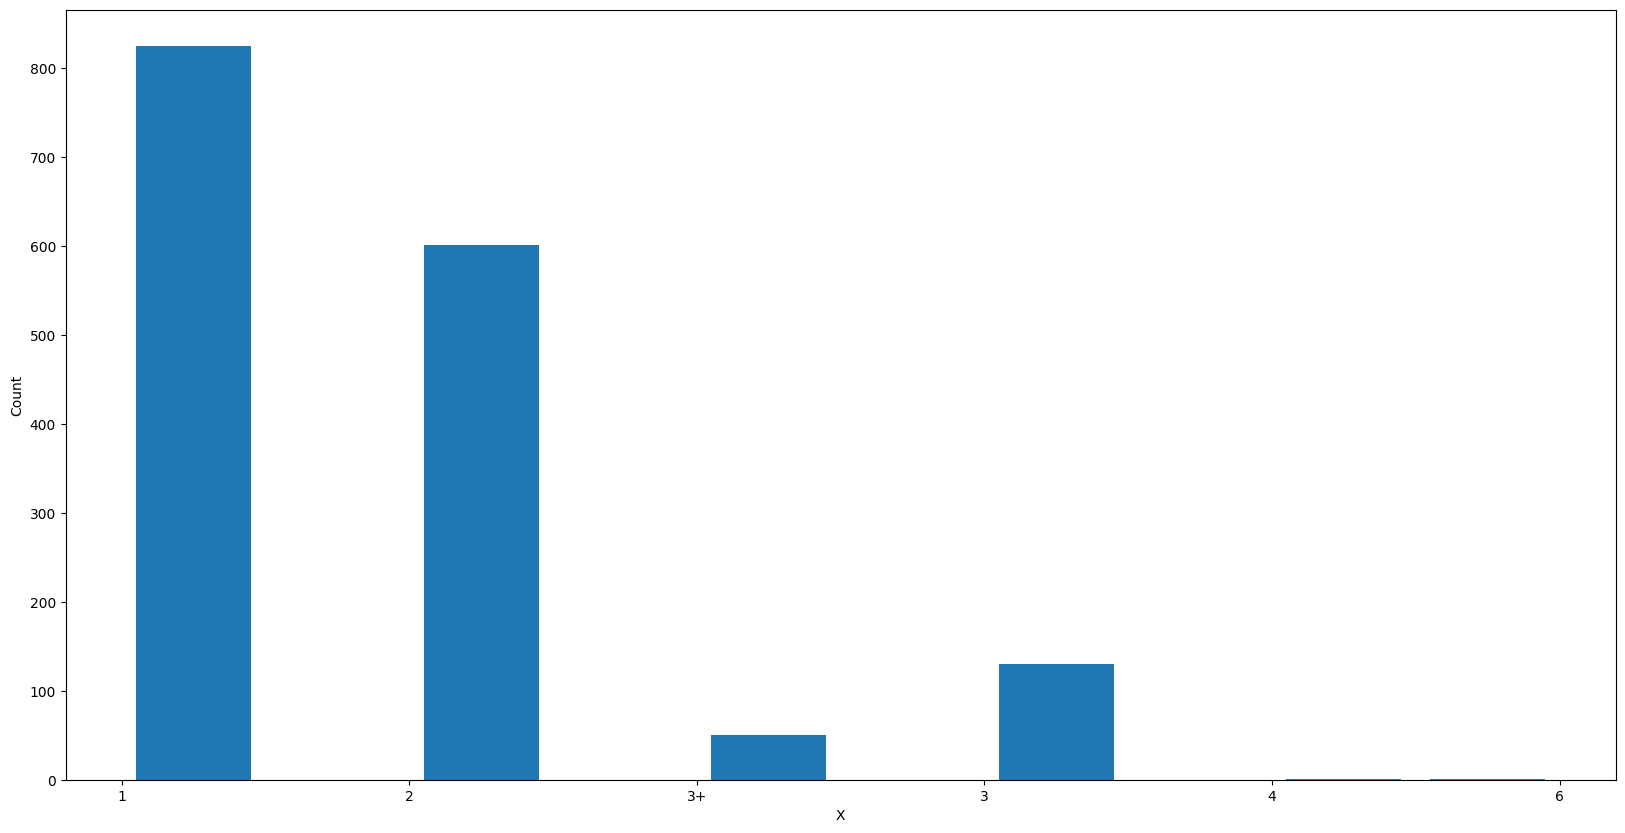

In [ ]:
plt.hist(df4.bathrooms,rwidth=0.8)
plt.xlabel('X')
plt.ylabel('Count')

In [ ]:
df4['temp_rooms'] = df4['rooms']
df4['temp_rooms'] = df4['temp_rooms'].replace('5+', '6')
df4.loc[df4['bathrooms'] == '3+', ['bathrooms']] = df4.temp_rooms.astype(int)+1
df4.shape

(1607, 10)

In [ ]:
df5 = df4[df4.bathrooms.astype(int)<df4.temp_rooms.astype(int)+2]
df5.shape

(1605, 10)

Text(0, 0.5, 'Count')

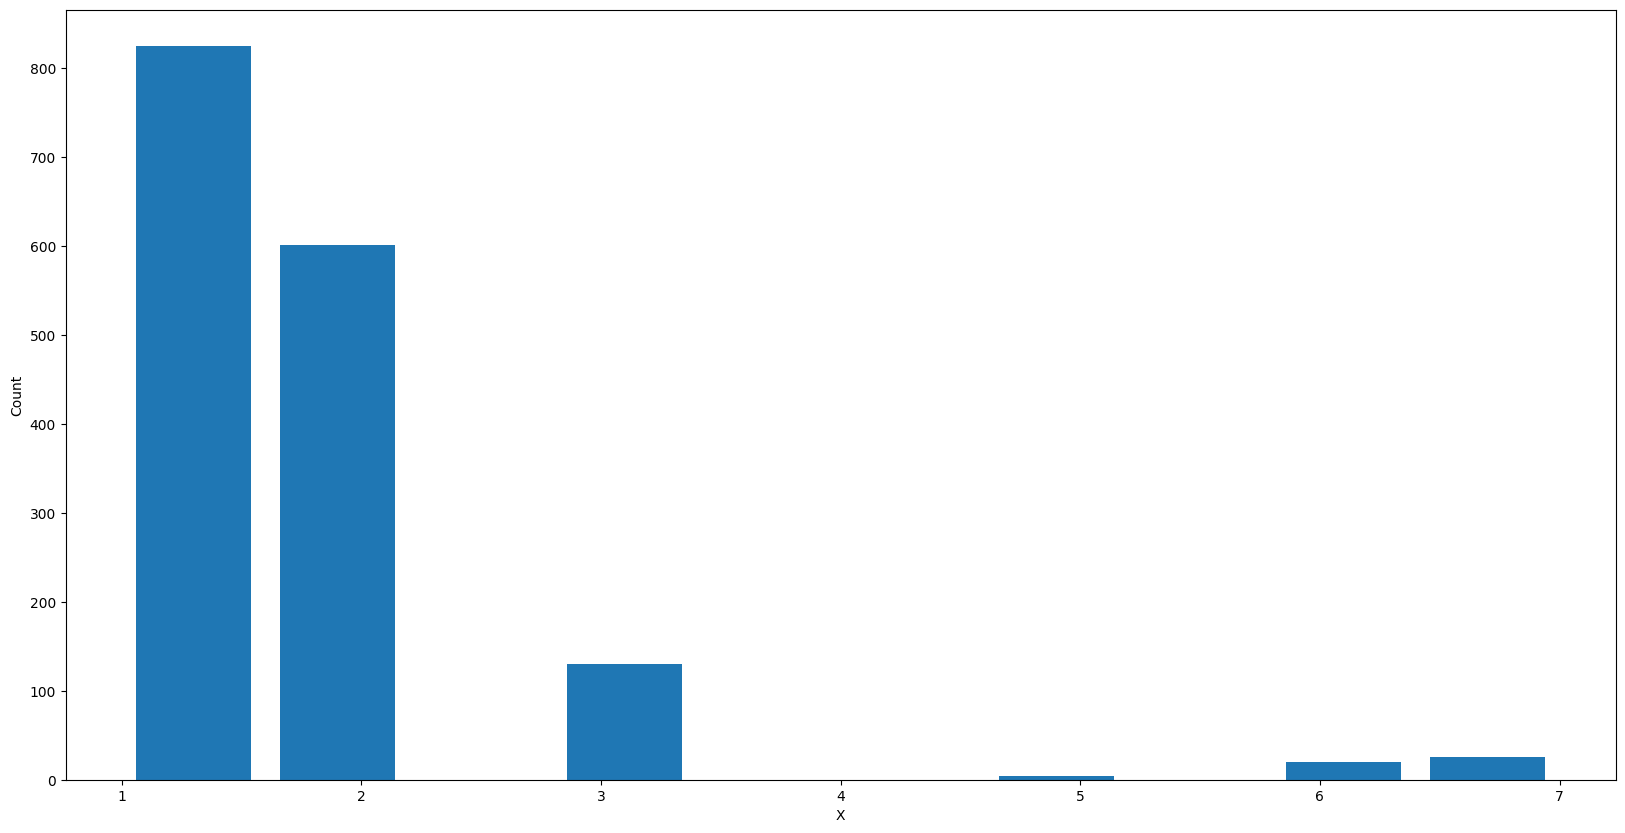

In [ ]:
plt.hist(df5.bathrooms.astype(int),rwidth=0.8)
plt.xlabel('X')
plt.ylabel('Count')

In [ ]:
df5

,rooms,m2,bathrooms,price,year_of_build,neighborhood,heating_centralized,elevator,price_per_sqm,temp_rooms
0,2,75.0,1,219000.0,1960.0,affori,centralized,1,2920.000000,2
1,4,120.0,2,429000.0,1970.0,affori,centralized,1,3575.000000,4
2,2,46.0,1,185000.0,1950.0,affori,centralized,0,4021.739130,2
3,2,65.0,1,260000.0,2005.0,affori,autonomous,0,4000.000000,2
4,2,45.0,1,159000.0,1930.0,affori,autonomous,0,3533.333333,2
...,...,...,...,...,...,...,...,...,...,...
1602,2,51.0,1,340000.0,1960.0,zara,centralized,1,6666.666667,2
1603,5,170.0,2,805000.0,1920.0,zara,autonomous,0,4735.294118,5
1604,3,95.0,1,550000.0,1950.0,zara,centralized,1,5789.473684,3
1605,4,120.0,2,690000.0,1960.0,zara,centralized,1,5750.000000,4


## Model Building

In [ ]:
df5['heating_centralized'] = df5['heating_centralized'].replace('autonomous', 1)
df5['heating_centralized'] = df5['heating_centralized'].replace('centralized', 0)
ohe_neighborhood = pd.get_dummies(df5.neighborhood)
ohe_neighborhood

<ipython-input-140-43dbfed84de8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['heating_centralized'] = df5['heating_centralized'].replace('autonomous', 1)
<ipython-input-140-43dbfed84de8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['heating_centralized'] = df5['heating_centralized'].replace('centralized', 0)


,affori,amendola - buonarroti,arco della pace,arena,argonne - corsica,baggio,bande nere,barona,bicocca,bignami - ponale,...,tripoli - soderini,turati,turro,vercelli - wagner,viale ungheria - mecenate,vigentino - fatima,villa san giovanni,vincenzo monti,washington,zara
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1604,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df6 = pd.concat([df5,ohe_neighborhood.drop('other',axis='columns')],axis='columns')
df6['rooms'] = df6['temp_rooms'].astype(int)
df6.drop(['neighborhood','price_per_sqm','temp_rooms'],axis='columns',inplace=True)
df6.head()

,rooms,m2,bathrooms,price,year_of_build,heating_centralized,elevator,affori,amendola - buonarroti,arco della pace,...,tripoli - soderini,turati,turro,vercelli - wagner,viale ungheria - mecenate,vigentino - fatima,villa san giovanni,vincenzo monti,washington,zara
0,2,75.0,1,219000.0,1960.0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,120.0,2,429000.0,1970.0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,46.0,1,185000.0,1950.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,65.0,1,260000.0,2005.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,45.0,1,159000.0,1930.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df6.shape

(1605, 114)

In [ ]:
X = df6.drop('price',axis='columns')
X.head()

,rooms,m2,bathrooms,year_of_build,heating_centralized,elevator,affori,amendola - buonarroti,arco della pace,arena,...,tripoli - soderini,turati,turro,vercelli - wagner,viale ungheria - mecenate,vigentino - fatima,villa san giovanni,vincenzo monti,washington,zara
0,2,75.0,1,1960.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,120.0,2,1970.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,46.0,1,1950.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,65.0,1,2005.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,45.0,1,1930.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = df6.price
y.head()

0    219000.0
1    429000.0
2    185000.0
3    260000.0
4    159000.0
Name: price, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)

LinearRegression()

In [ ]:
lr_clf.score(X_test,y_test)

0.8243414928401631

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82434149, 0.4242796 , 0.85087753, 0.43136205, 0.38330456,
       0.82655359, 0.82836689, 0.81700994, 0.83940149, 0.50297633])

In [ ]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def find_best_model_gscv(X,y):
  algos = {
      'linear_regression' : {
          'model': LinearRegression(),
          'params': {
              'fit_intercept': [True, False]
          }
      },
      'lasso': {
          'model': Lasso(),
          'params': {
              'alpha': [1,2],
              'selection': ['random','cyclic']
          }
      },
      'decision_tree': {
          'model': DecisionTreeRegressor(),
          'params': {
              'criterion': ['mse','friedman_mse'],
              'splitter': ['best','random']
          }
      },
      'random_forest': {
          'model': RandomForestRegressor(),
          'params': {
              'criterion': ['squared_error','friedman_mse']
          }
      }
  }
  scores = []
  cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
  for algo_name, config in algos.items():
    gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    gs.fit(X,y)
    scores.append({
        'model': algo_name,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })
  return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_gscv(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _valida

,model,best_score,best_params
0,linear_regression,0.831794,{'fit_intercept': True}
1,lasso,0.831836,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.680602,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
3,random_forest,0.806423,{'criterion': 'friedman_mse'}


In [ ]:
def predict_price(neighborhood,sqm,bath,rooms,yob,heating,elevator):
  loc_index = np.where(X.columns==neighborhood)[0][0]
  x = np.zeros(len(X.columns))
  x[0] = rooms
  x[1] = sqm
  x[2] = bath
  x[3] = yob
  x[4] = heating
  x[5] = elevator
  if loc_index >= 0:
    x[loc_index] = 1
  return lr_clf.predict([x])[0]

In [ ]:
predict_price('cimiano',120,1,5,2007,1,1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


565285.7751581008

In [ ]:
# Save model as pickle file
with open('mhpp_lr_model.pkl','wb') as f:
  pickle.dump(lr_clf,f)

In [ ]:
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open('columns.json','w') as f:
  f.write(json.dumps(columns))